# Using a Decision Tree to predict the severity of a defect

### Import the libraries and data

In [10]:
# import libraries
%pip install seaborn matplotlib pandas scikit-learn numpy kagglehub missingno


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kagglehub

import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:

# Download the latest version of the dataset
path = kagglehub.dataset_download("fahmidachowdhury/manufacturing-defects")

# Construct the file path to the dataset
file_path = f"{path}/defects_data.csv"

# Load the dataset using the dynamically generated file path
defects = pd.read_csv(file_path)

# Ensure the dataset is loaded
if 'defects' not in locals():
	path = kagglehub.dataset_download("fahmidachowdhury/manufacturing-defects")
	file_path = f"{path}/defects_data.csv"
	defects = pd.read_csv(file_path)

# View the first few rows of the dataset to confirm it loaded correctly
print("Dataset loaded successfully!")

# Quick data overview
print(defects.info())
print(defects['severity'].value_counts(normalize=True))

Dataset loaded successfully!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB
None
severity
Minor       0.358
Critical    0.333
Moderate    0.309
Name: proportion, dtype: float64


### Exploratory Data Analysis

In [12]:
# display summary statistics of the dataset
defects.describe()

,defect_id,product_id,repair_cost
count,1000.000000,1000.000000,1000.000000
mean,500.500000,50.837000,507.627150
std,288.819436,29.480935,289.623615
min,1.000000,1.000000,10.220000
25%,250.750000,26.000000,270.902500
50%,500.500000,51.000000,506.430000
75%,750.250000,77.000000,759.065000
max,1000.000000,100.000000,999.640000


Summary of Missing Values (by Column):
defect_id            0
product_id           0
defect_type          0
defect_date          0
defect_location      0
severity             0
inspection_method    0
repair_cost          0
dtype: int64

 Any Missing Values?  False


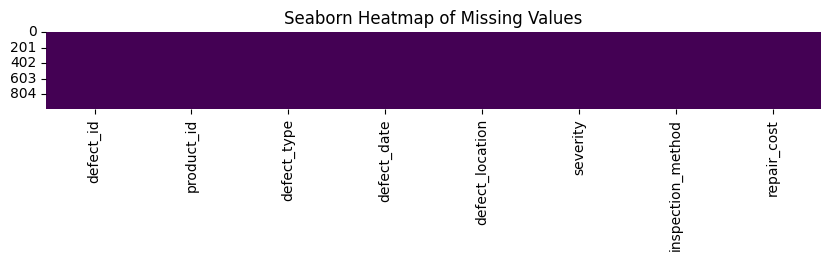

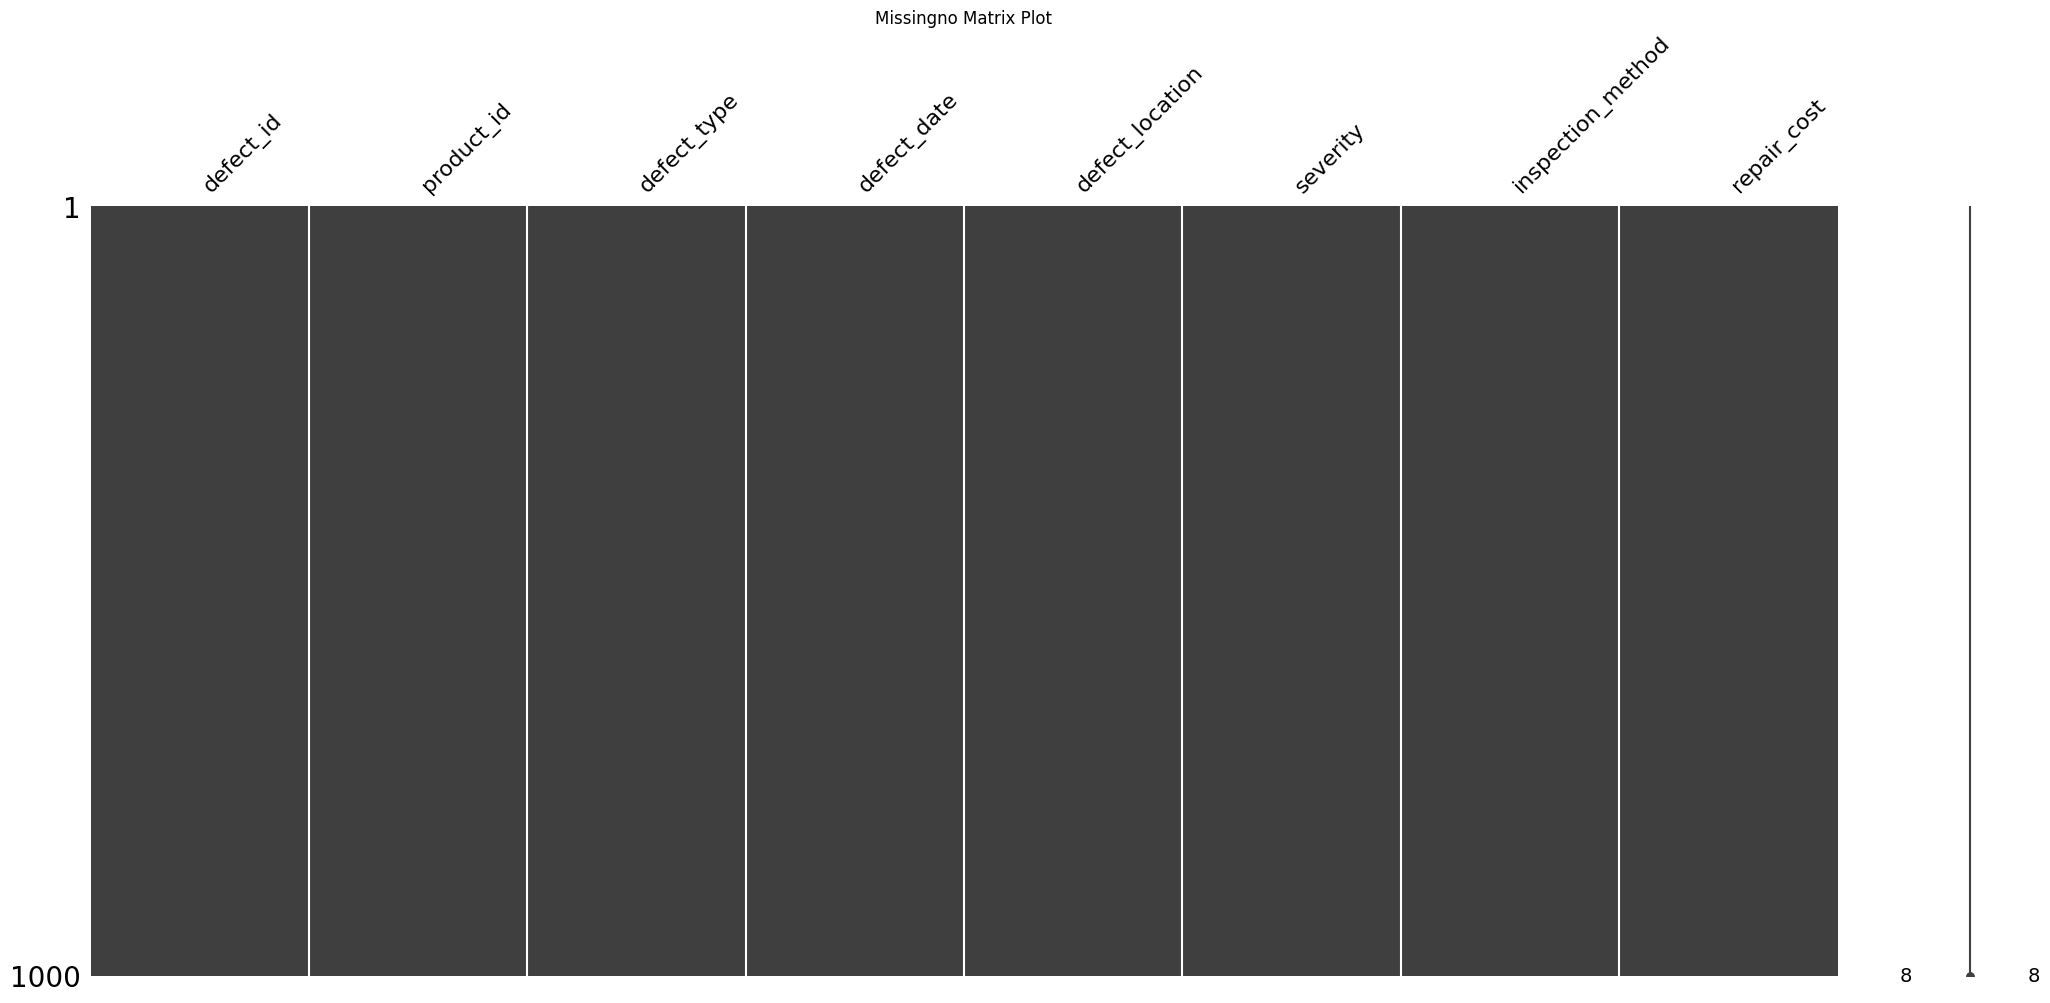

In [13]:
# Ensure missingno is installed

import missingno as msno

def check_missing_values(df):
    """
    Displays a numerical and visual summary of missing values for the defects dataset.
    """
    print("Summary of Missing Values (by Column):")
    print(df.isnull().sum())
    print("\n Any Missing Values? ", df.isnull().values.any())

    # Seaborn Heatmap
    plt.figure(figsize=(10, 1))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
    plt.title('Seaborn Heatmap of Missing Values')
    plt.show()

    # Missingno Matrix
    msno.matrix(df)
    plt.title('Missingno Matrix Plot')
    plt.show()

check_missing_values(defects)

##### Preliminary data quality assessment confirmed that all columns were complete, with no missing values present. Several features were identified as categorical and may require transformation into dummy (indicator) variables to support algorithm compatibility and ensure proper model interpretation.  


##### In addition, observations labeled as 'critical' in the severity variable warrant further investigation to assess their distribution and potential associations with other predictors.

In [14]:
# Identify and List out Categorical Columns 
categorical_cols = defects.select_dtypes(include=['object', 'category']).columns
print("Categorical columns:", categorical_cols.tolist())


Categorical columns: ['defect_type', 'defect_date', 'defect_location', 'severity', 'inspection_method']


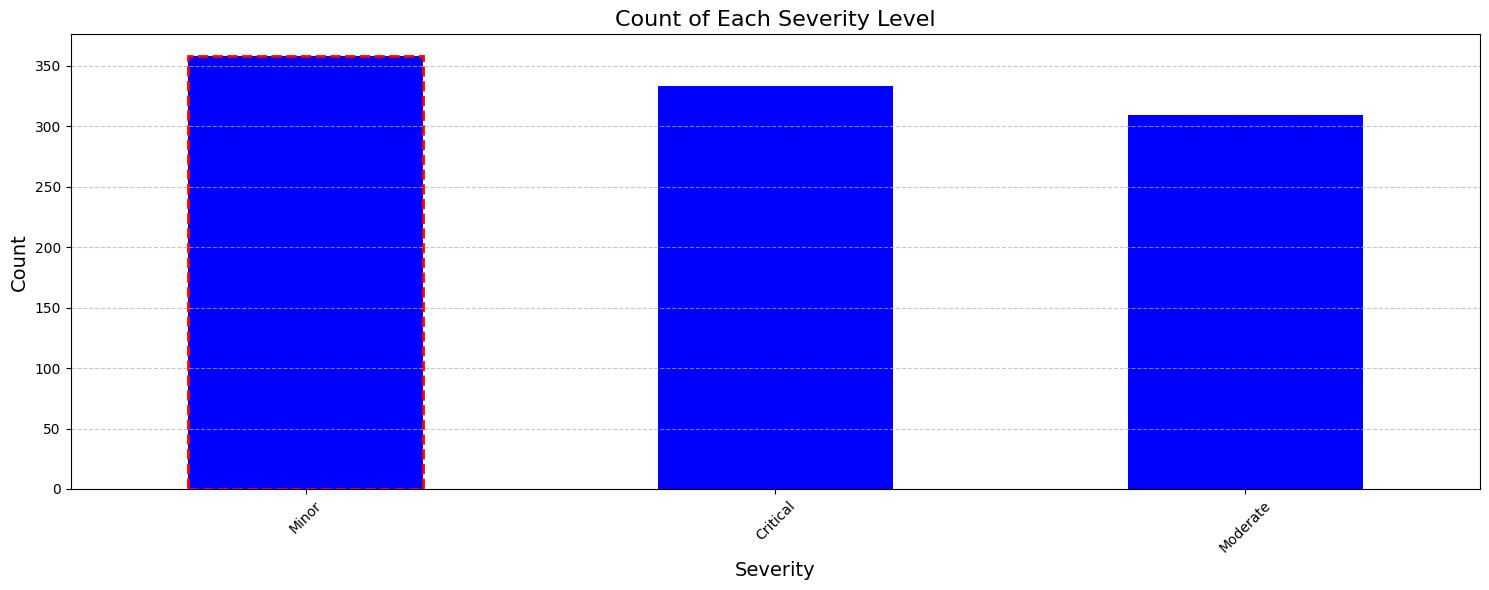

In [15]:
# check the distribution of the severity feature

#create a bar plot of the severity feature
plt.figure(figsize=(15, 6))
severity_count = defects['severity'].value_counts()
bars = severity_count.plot(kind="bar", color='blue')


# Find the largest bar
max_value = severity_count.max()
max_height_with_tolerance = max_value * 1.2  # Add a tolerance of 20%
max_index = severity_count[severity_count <= max_height_with_tolerance].idxmax()


# Get the index of the largest bar in the patches list
largest_bar_index = severity_count.index.get_loc(max_index)
largest_bar = bars.patches[largest_bar_index]

# Add a dashed rectangle around the largest bar
plt.gca().add_patch(plt.Rectangle(
    (largest_bar.get_x(), 0),  # Bottom-left corner of the bar
    largest_bar.get_width(),  # Width of the bar
    largest_bar.get_height(),  # Height of the bar
    edgecolor='red',          # Color of the dashed line
    linestyle='--',           # Dashed line style
    linewidth=2,              # Thickness of the line
    fill=False                # No fill
))


# Add labels to the bars
plt.title('Count of Each Severity Level', fontsize=16)
plt.xlabel('Severity', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

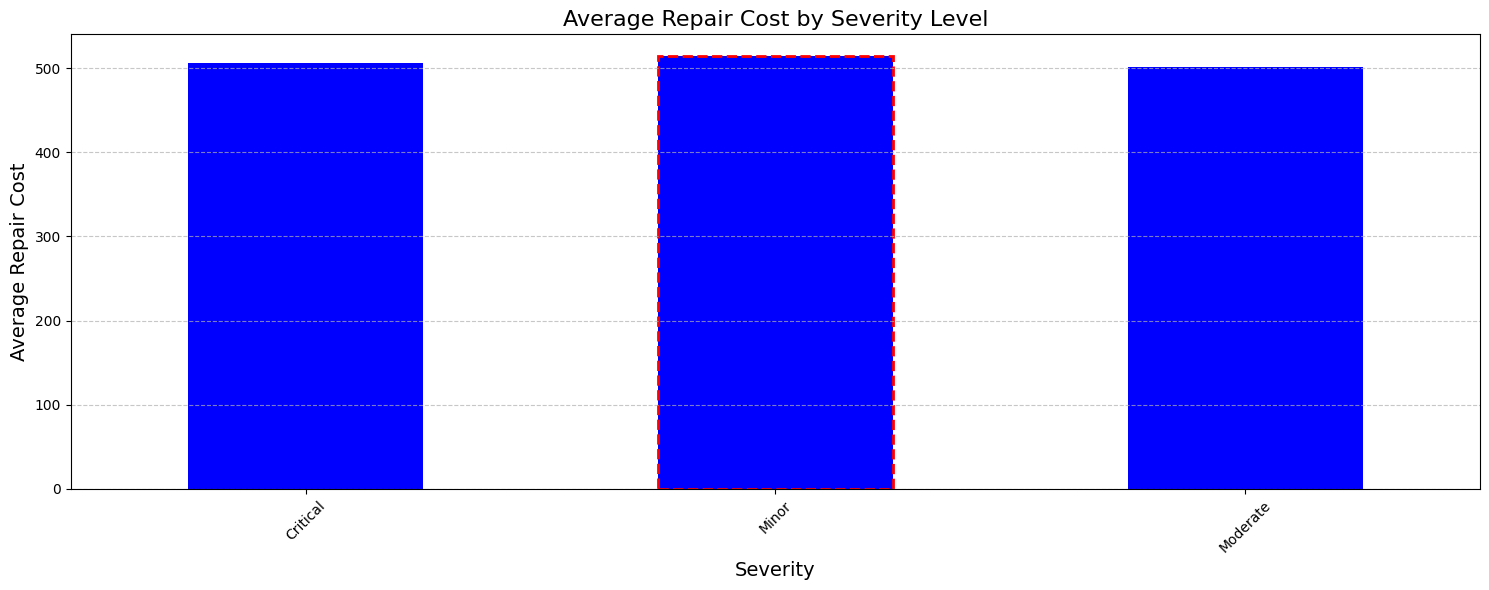

In [16]:
# Calculate the average repair cost for each severity level
avg_repair_cost = defects.groupby('severity')['repair_cost'].mean()

# Create a bar plot of the average repair cost for each severity level
plt.figure(figsize=(15, 6))
bars = avg_repair_cost.plot(kind="bar", color='blue')  # Capture the bars object

# Find the largest bar
max_value = avg_repair_cost.max()
max_height_with_tolerance = max_value * 1.2  # Add a tolerance of 10%
max_index = avg_repair_cost[avg_repair_cost <= max_height_with_tolerance].idxmax()

# Get the index of the largest bar in the patches list
largest_bar_index = avg_repair_cost.index.get_loc(max_index)
largest_bar = bars.patches[largest_bar_index]  # Access the bar patch

# Add a dashed rectangle around the largest bar
plt.gca().add_patch(plt.Rectangle(
    (largest_bar.get_x(), 0),  # Bottom-left corner of the bar
    largest_bar.get_width(),  # Width of the bar
    largest_bar.get_height(),  # Height of the bar
    edgecolor='red',          # Color of the dashed line
    linestyle='--',           # Dashed line style
    linewidth=2,              # Thickness of the line
    fill=False                # No fill
))

# Add labels to the bars
plt.title('Average Repair Cost by Severity Level', fontsize=16)
plt.xlabel('Severity', fontsize=14)
plt.ylabel('Average Repair Cost', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

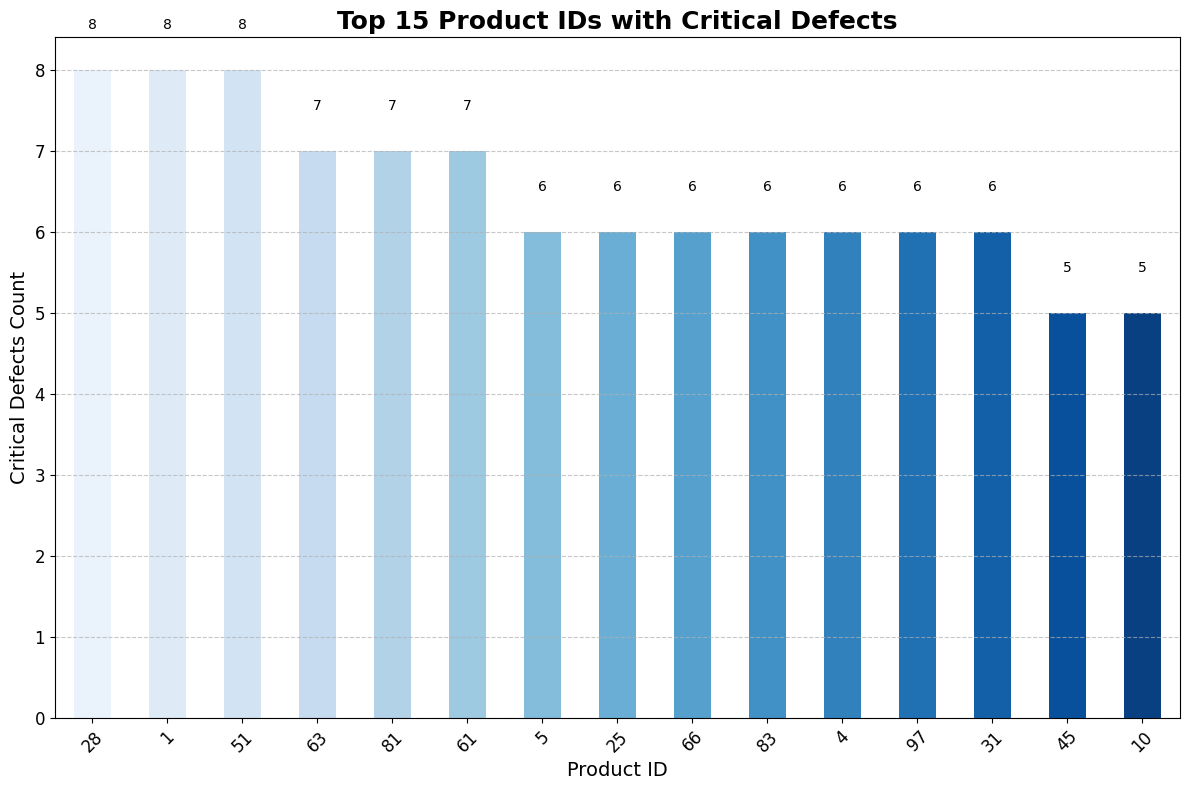

In [17]:
# Visual Changed bar plot for critical defects by Product ID, Only showing the top 15
plt.figure(figsize=(12, 8))  

# Filter and count critical defects by product ID
critical_defects = defects[defects['severity'] == 'Critical']
critical_by_id = critical_defects['product_id'].value_counts()
top_15_critical = critical_by_id.sort_values(ascending=False).head(15)  

# Create the bar plot
bars = top_15_critical.plot(kind="bar", color=sns.color_palette("Blues", len(top_15_critical)))

# Add exact count values on top of each bar
for i, count in enumerate(top_15_critical):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=10, color='black')

# Add labels and title
plt.title('Top 15 Product IDs with Critical Defects', fontsize=18, fontweight='bold')
plt.xlabel('Product ID', fontsize=14)
plt.ylabel('Critical Defects Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

### Create a Decision Tree to predict the severity level of the defect

In [18]:
from datetime import datetime

# Define the extract_month function
def extract_month(x):
    date = datetime.strptime(x, "%m/%d/%Y")
    return date.month

defects.info()
# Handle errors during data processing
try:
    defects["month"] = defects["defect_date"].apply(extract_month)
except KeyError as e:
    print(f"Missing column in dataset: {e}")
except Exception as e:
    print(f"Error processing data: {e}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   defect_id          1000 non-null   int64  
 1   product_id         1000 non-null   int64  
 2   defect_type        1000 non-null   object 
 3   defect_date        1000 non-null   object 
 4   defect_location    1000 non-null   object 
 5   severity           1000 non-null   object 
 6   inspection_method  1000 non-null   object 
 7   repair_cost        1000 non-null   float64
dtypes: float64(1), int64(2), object(5)
memory usage: 62.6+ KB


In [19]:
import calendar

# Map numerical month values to month names
defects['month'] = defects['month'].apply(lambda x: calendar.month_name[x])


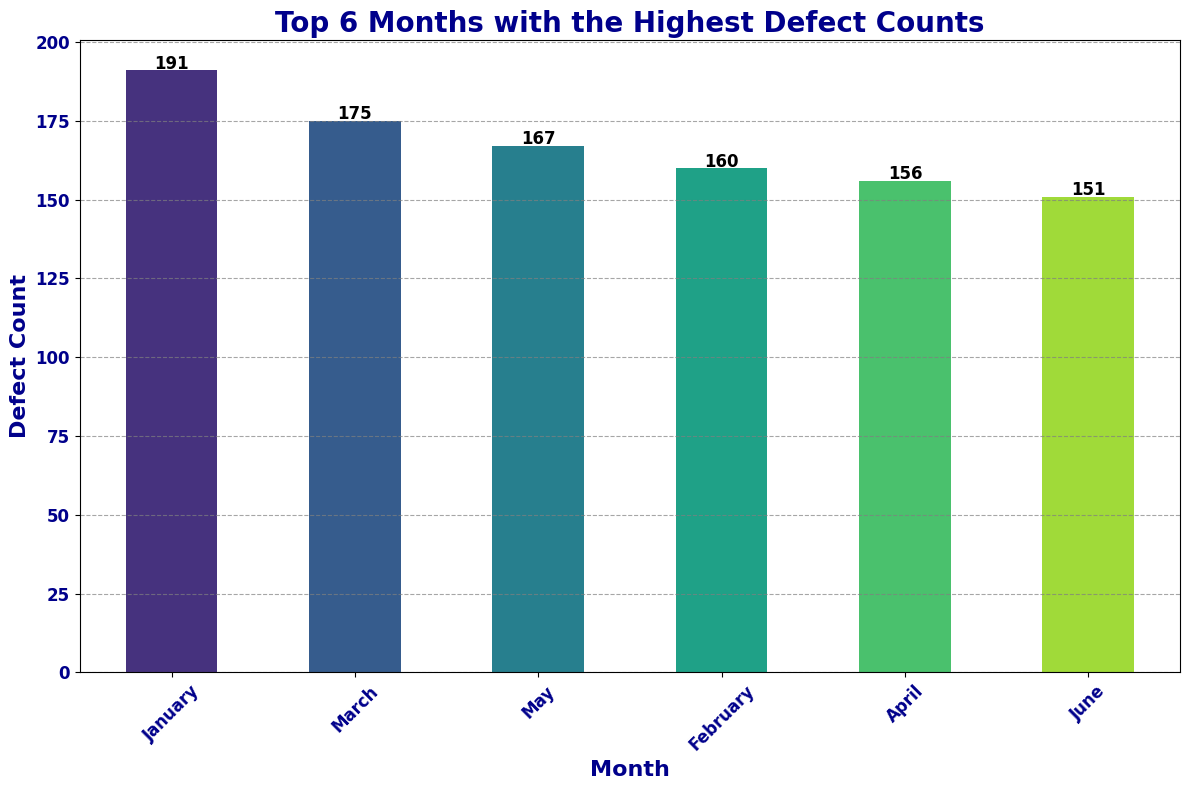

In [20]:
# Distribution Bar plot for the top 6 months with the highest defect counts
plt.figure(figsize=(12, 8))  

# Get the top 6 months with the highest defect counts
top_6_months = defects['month'].value_counts().head(6)

# Create the bar plot with a vibrant color palette
bars = top_6_months.plot(kind="bar", color=sns.color_palette("viridis", len(top_6_months)))

# Add exact count values on top of each bar
for i, count in enumerate(top_6_months):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12, color='black', fontweight='bold')

# Add labels and title with bold styling
plt.title('Top 6 Months with the Highest Defect Counts', fontsize=20, fontweight='bold', color='darkblue')
plt.xlabel('Month', fontsize=16, fontweight='bold', color='darkblue')
plt.ylabel('Defect Count', fontsize=16, fontweight='bold', color='darkblue')

# Customize ticks for better readability
plt.xticks(rotation=45, fontsize=12, fontweight='bold', color='darkblue')
plt.yticks(fontsize=12, fontweight='bold', color='darkblue')

# Add a grid with enhanced styling
plt.grid(axis='y', linestyle='--', alpha=0.7, color='gray')

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [21]:
# Prepare the data for modeling
X = defects.drop(columns=['severity', 'defect_date'])
y = defects['severity']


In [22]:
# check to make sure the data loaded correctly
X.head()

,defect_id,product_id,defect_type,defect_location,inspection_method,repair_cost,month
0,1,15,Structural,Component,Visual Inspection,245.47,June
1,2,6,Functional,Component,Visual Inspection,26.87,April
2,3,84,Structural,Internal,Automated Testing,835.81,February
3,4,10,Functional,Internal,Automated Testing,444.47,March
4,5,14,Cosmetic,Component,Manual Testing,823.64,April


In [23]:
# check to make sure the data counts remain the same
X['month'].value_counts()

month
January     191
March       175
May         167
February    160
April       156
June        151
Name: count, dtype: int64

In [24]:
# check the target variable to make sure it loaded correctly
y.head()

0       Minor
1       Minor
2       Minor
3    Critical
4       Minor
Name: severity, dtype: object

In [25]:
# convert y to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

In [26]:
# check the target variable to make sure it transformed correctly
print(y[0:10])

[1 1 1 0 1 2 0 2 0 0]


In [27]:
# One-hot encode categorical features in X
X = pd.get_dummies(X)

In [28]:
# inspect the transformed features
print(X.head())

   defect_id  product_id  repair_cost  defect_type_Cosmetic  \
0          1          15       245.47                 False   
1          2           6        26.87                 False   
2          3          84       835.81                 False   
3          4          10       444.47                 False   
4          5          14       823.64                  True   

   defect_type_Functional  defect_type_Structural  defect_location_Component  \
0                   False                    True                       True   
1                    True                   False                       True   
2                   False                    True                      False   
3                    True                   False                      False   
4                   False                   False                       True   

   defect_location_Internal  defect_location_Surface  \
0                     False                    False   
1                     False 

In [29]:
#inspect the transformed features
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   defect_id                            1000 non-null   int64  
 1   product_id                           1000 non-null   int64  
 2   repair_cost                          1000 non-null   float64
 3   defect_type_Cosmetic                 1000 non-null   bool   
 4   defect_type_Functional               1000 non-null   bool   
 5   defect_type_Structural               1000 non-null   bool   
 6   defect_location_Component            1000 non-null   bool   
 7   defect_location_Internal             1000 non-null   bool   
 8   defect_location_Surface              1000 non-null   bool   
 9   inspection_method_Automated Testing  1000 non-null   bool   
 10  inspection_method_Manual Testing     1000 non-null   bool   
 11  inspection_method_Visual Inspec

In [30]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
# Fit the decision tree model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [32]:
# predict the target variable for the test set and evaluate the model
y_pred_dt = dt.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"Decision Tree Accuracy: {accuracy_dt:.2f}")
print(classification_report(y_test, y_pred_dt, target_names=le.classes_))
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix:\n", cm_dt)

Decision Tree Accuracy: 0.32
              precision    recall  f1-score   support

    Critical       0.32      0.37      0.35        97
       Minor       0.34      0.34      0.34       115
    Moderate       0.28      0.24      0.26        88

    accuracy                           0.32       300
   macro avg       0.32      0.32      0.31       300
weighted avg       0.32      0.32      0.32       300

Confusion Matrix:
 [[36 40 21]
 [43 39 33]
 [32 35 21]]


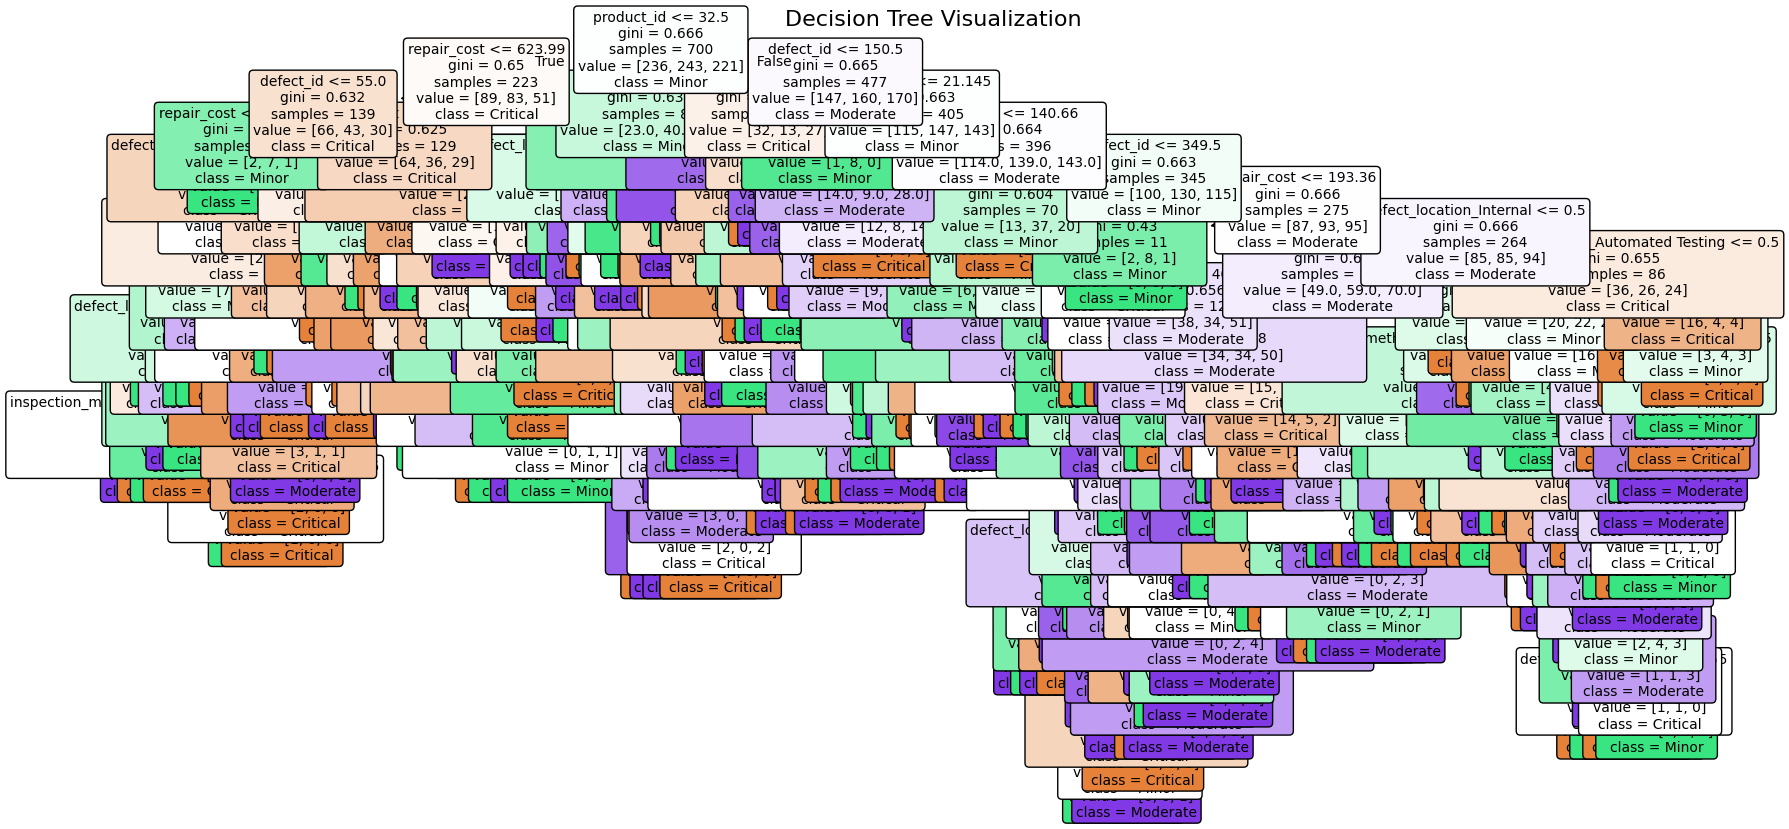

In [33]:
# Visualize the decision tree to understand the most important features.

plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, class_names=le.classes_, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()


##### The primary decision was product_id with a secondary condition being defect_id which is a unique identifier for each instance.

#### Create a Decision Tree without the defect_id feature to simplify the tree. Compare to see if the performance improves

In [34]:
# prepare the data for modeling

# split into X and y. remove the defect_id column from the dataset
X_no_id = defects.drop(columns=['severity', 'defect_date', 'defect_id'])
y = defects['severity']

In [35]:
# convert y to numerical values
le = LabelEncoder()
y = le.fit_transform(y)

In [36]:
# One-hot encode categorical features in X_no_id
X_no_id = pd.get_dummies(X_no_id)

In [37]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_no_id, y, test_size=0.3, random_state=42)

In [38]:
# Fit the decision tree model
dt_no_id = DecisionTreeClassifier(random_state=42)
dt_no_id.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [39]:
# predict the target variable for the test set and evaluate the model
y_pred_dt_no_id = dt_no_id.predict(X_test)
accuracy_dt_no_id = accuracy_score(y_test, y_pred_dt_no_id)
print(f"Decision Tree Accuracy: {accuracy_dt_no_id:.2f}")
print(classification_report(y_test, y_pred_dt_no_id, target_names=le.classes_))
cm_dt_no_id = confusion_matrix(y_test, y_pred_dt_no_id)
print("Confusion Matrix:\n", cm_dt_no_id)

Decision Tree Accuracy: 0.29
              precision    recall  f1-score   support

    Critical       0.24      0.26      0.25        97
       Minor       0.36      0.33      0.35       115
    Moderate       0.28      0.28      0.28        88

    accuracy                           0.29       300
   macro avg       0.29      0.29      0.29       300
weighted avg       0.30      0.29      0.29       300

Confusion Matrix:
 [[25 38 34]
 [46 38 31]
 [34 29 25]]


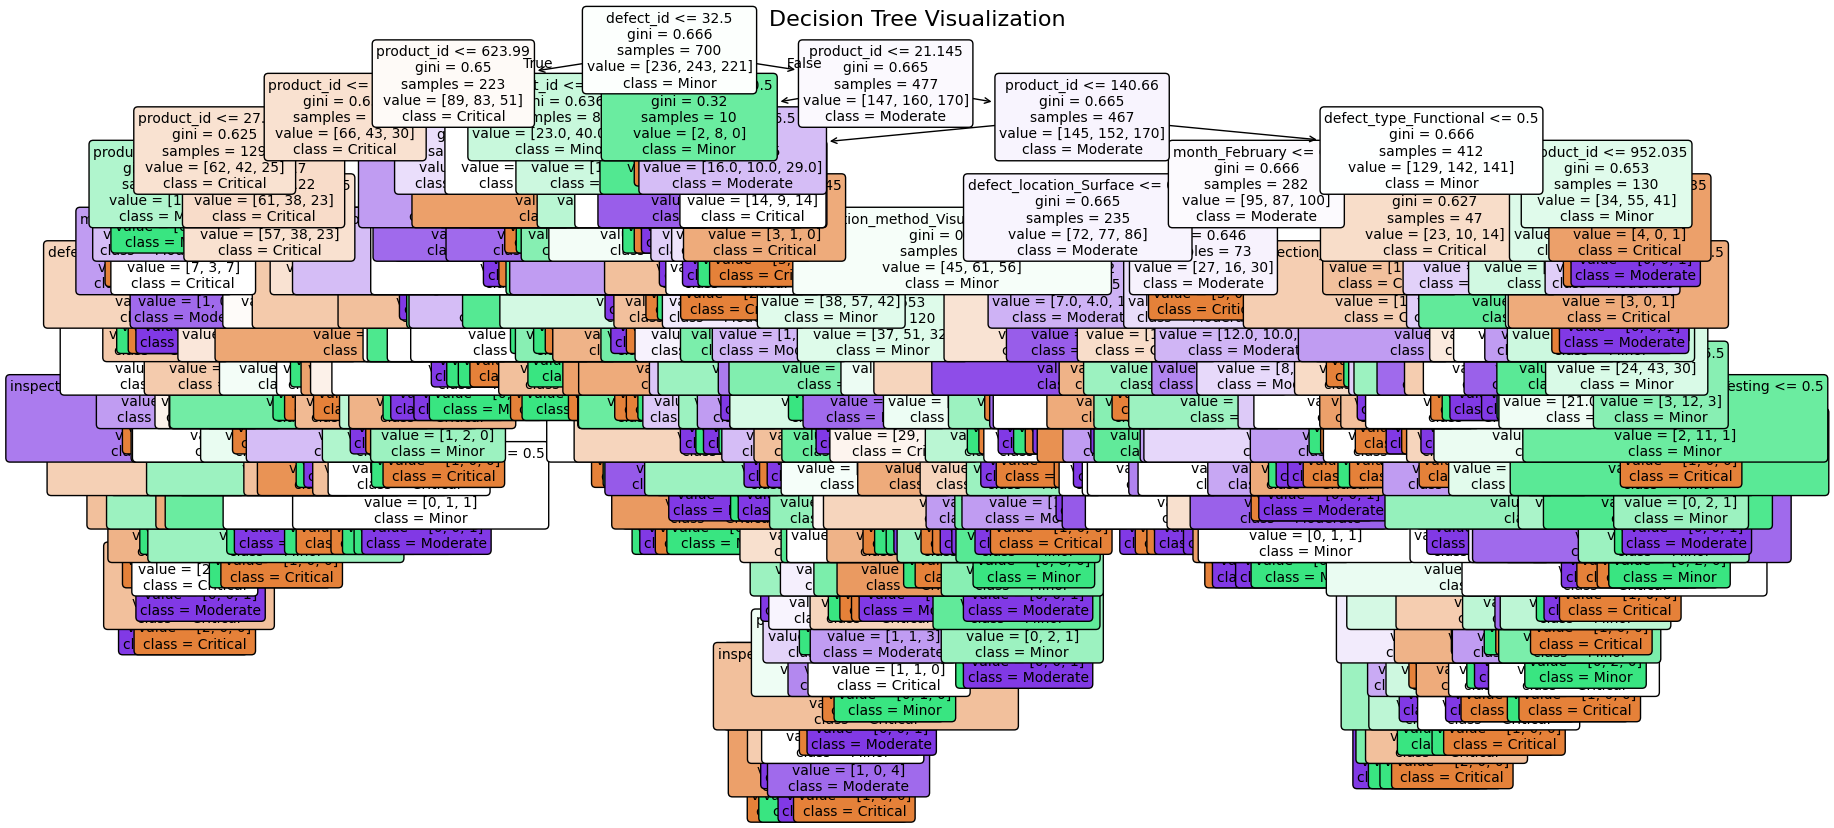

In [40]:
# Visualize the decision tree to understand the most important features.

plt.figure(figsize=(20, 10))
plot_tree(dt_no_id, feature_names=X.columns, class_names=le.classes_, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Visualization", fontsize=16)
plt.show()


### Create a Random Forest to predict the severity of the defect

In [41]:
# Train the Random Forest model
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [42]:
# Predict and evaluate
y_pred_rf = rf_clf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

print(classification_report(y_test, y_pred_rf, target_names=le.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:\n", cm_rf)

Random Forest Accuracy: 0.32
              precision    recall  f1-score   support

    Critical       0.34      0.39      0.36        97
       Minor       0.38      0.36      0.37       115
    Moderate       0.23      0.20      0.22        88

    accuracy                           0.32       300
   macro avg       0.31      0.32      0.31       300
weighted avg       0.32      0.32      0.32       300

Confusion Matrix:
 [[38 32 27]
 [41 41 33]
 [34 36 18]]


##### Create a Random Forest without the defect_id

In [43]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_no_id, y, test_size=0.3, random_state=42)

In [44]:
# Train the Random Forest model
rf_no_id = RandomForestClassifier(n_estimators=100, random_state=42)
rf_no_id.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [45]:
# Predict and evaluate
y_pred_rf_no_id = rf_no_id.predict(X_test)

accuracy_rf_no_id = accuracy_score(y_test, y_pred_rf_no_id)
print(f"Random Forest Accuracy: {accuracy_rf_no_id:.2f}")

print(classification_report(y_test, y_pred_rf_no_id, target_names=le.classes_))

cm_rf_no_id = confusion_matrix(y_test, y_pred_rf_no_id)
print("Confusion Matrix:\n", cm_rf_no_id)

Random Forest Accuracy: 0.32
              precision    recall  f1-score   support

    Critical       0.34      0.39      0.36        97
       Minor       0.38      0.36      0.37       115
    Moderate       0.23      0.20      0.22        88

    accuracy                           0.32       300
   macro avg       0.31      0.32      0.31       300
weighted avg       0.32      0.32      0.32       300

Confusion Matrix:
 [[38 32 27]
 [41 41 33]
 [34 36 18]]


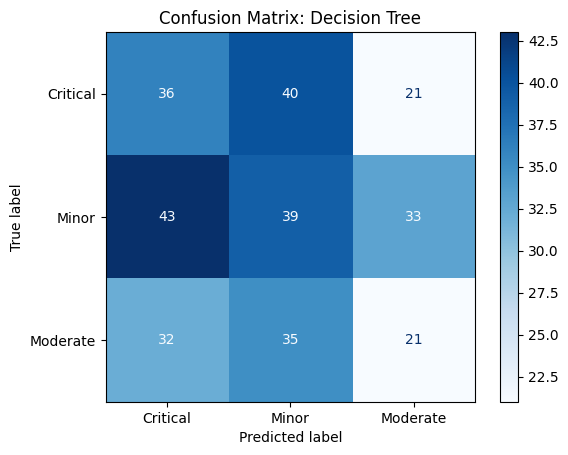

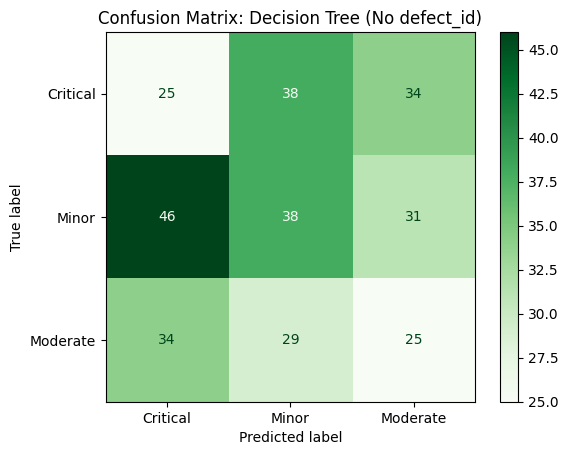

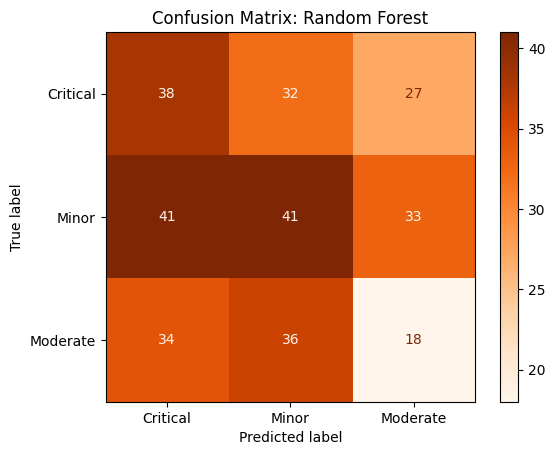

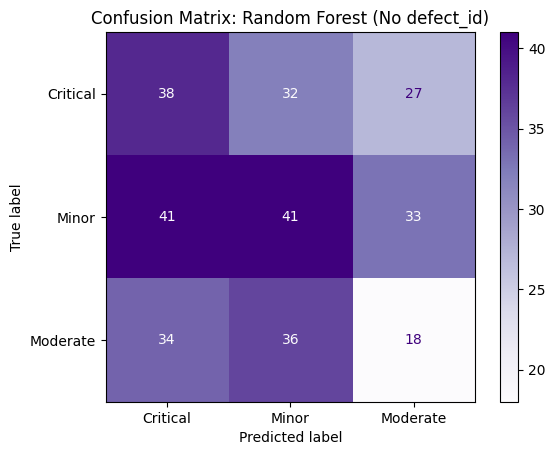

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

# Recompute confusion matrix for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)

# Visualize confusion matrix for Decision Tree
ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=le.classes_).plot(cmap='Blues')
plt.title("Confusion Matrix: Decision Tree")
plt.show()

# Visualize confusion matrix for Decision Tree without defect_id
ConfusionMatrixDisplay(confusion_matrix=cm_dt_no_id, display_labels=le.classes_).plot(cmap='Greens')
plt.title("Confusion Matrix: Decision Tree (No defect_id)")
plt.show()

# Visualize confusion matrix for Random Forest
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_).plot(cmap='Oranges')
plt.title("Confusion Matrix: Random Forest")
plt.show()

# Visualize confusion matrix for Random Forest without defect_id
ConfusionMatrixDisplay(confusion_matrix=cm_rf_no_id, display_labels=le.classes_).plot(cmap='Purples')
plt.title("Confusion Matrix: Random Forest (No defect_id)")
plt.show()

/tmp/ipykernel_44231/73582785.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette='viridis')


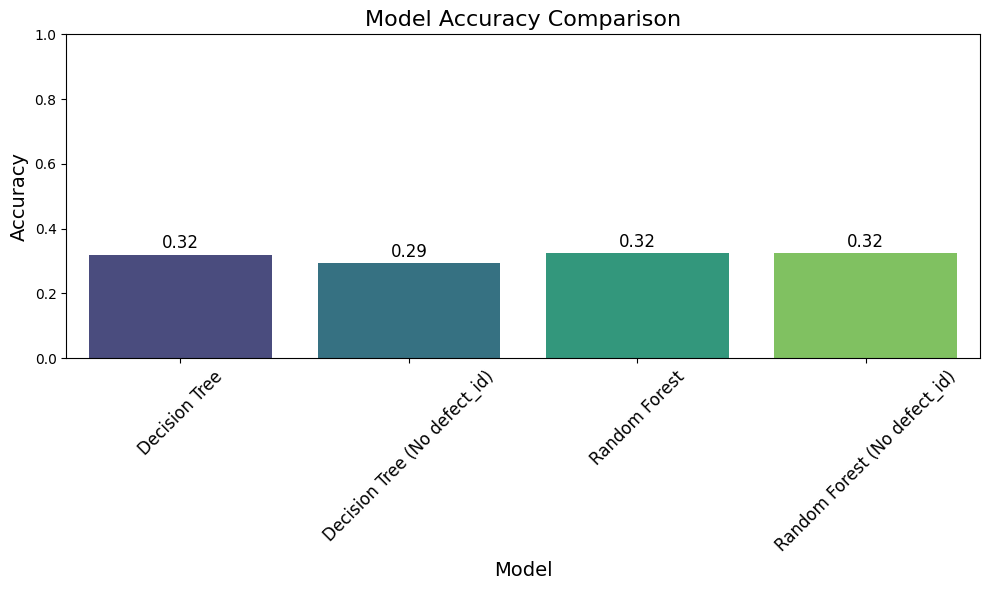

In [47]:
# Accuracy scores for models
models = ['Decision Tree', 'Decision Tree (No defect_id)', 'Random Forest', 'Random Forest (No defect_id)']
accuracies = [accuracy_dt, accuracy_dt_no_id, accuracy_rf, accuracy_rf_no_id]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies, palette='viridis')

# Add labels and title
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1

# Annotate accuracy values on bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()

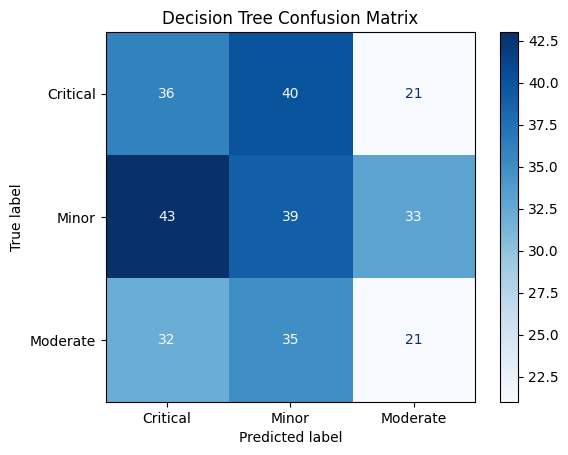

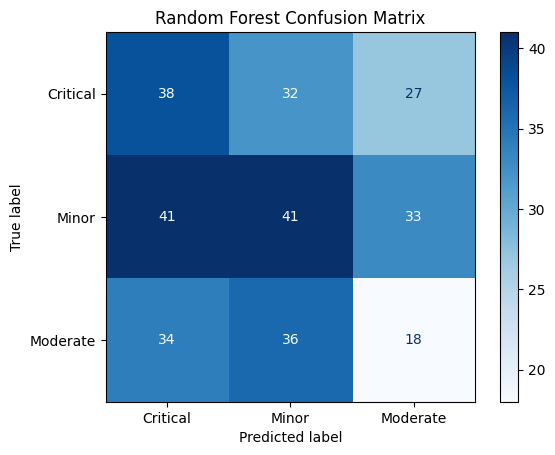

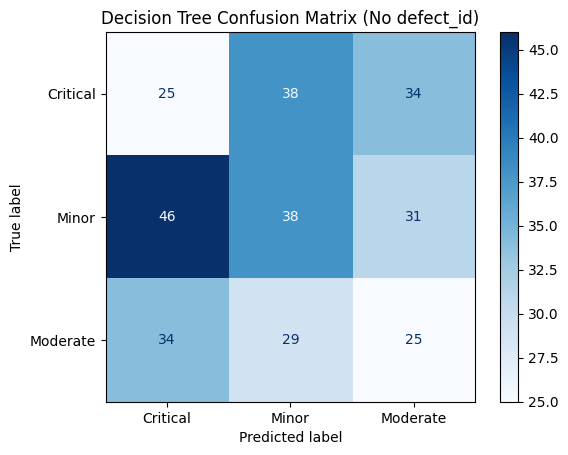

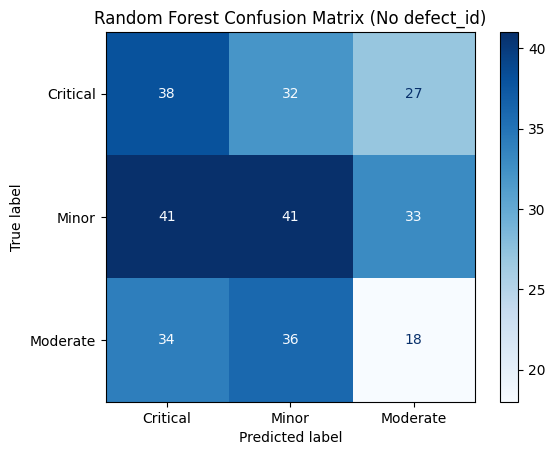

ValueError: The feature names should match those that were passed during fit.
Feature names must be in the same order as they were in fit.


In [50]:
##### To help visualize and coompare the performance of the models, we can create a confusion matrix and ROC curve for each model.
# Create a confusion matrix for the Decision Tree model
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=le.classes_)
disp_dt.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix")
plt.show()
# Create a confusion matrix for the Random Forest model
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=le.classes_)
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()
# Create a confusion matrix for the Decision Tree model without defect_id
cm_dt_no_id = confusion_matrix(y_test, y_pred_dt_no_id)
disp_dt_no_id = ConfusionMatrixDisplay(confusion_matrix=cm_dt_no_id, display_labels=le.classes_)
disp_dt_no_id.plot(cmap=plt.cm.Blues)
plt.title("Decision Tree Confusion Matrix (No defect_id)")
plt.show()
# Create a confusion matrix for the Random Forest model without defect_id
cm_rf_no_id = confusion_matrix(y_test, y_pred_rf_no_id)
disp_rf_no_id = ConfusionMatrixDisplay(confusion_matrix=cm_rf_no_id, display_labels=le.classes_)
disp_rf_no_id.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix (No defect_id)")   
plt.show()
# Ensure the test dataset includes the same features as the training dataset
X_test_with_id = X_test.copy()
X_test_with_id['defect_id'] = 0  # Add a placeholder column for defect_id

y_pred_proba_dt = dt.predict_proba(X_test_with_id)[:, 1]
y_pred_proba_rf = rf_clf.predict_proba(X_test_with_id)[:, 1]
y_pred_proba_dt_no_id = dt_no_id.predict_proba(X_test)[:, 1]
y_pred_proba_rf_no_id = rf_no_id.predict_proba(X_test)[:, 1]
# Create ROC curves for both models
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]
y_pred_proba_rf = rf_clf.predict_proba(X_test)[:, 1]
y_pred_proba_dt_no_id = dt_no_id.predict_proba(X_test)[:, 1]
y_pred_proba_rf_no_id = rf_no_id.predict_proba(X_test)[:, 1]
# Calculate ROC AUC scores
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
roc_auc_dt_no_id = roc_auc_score(y_test, y_pred_proba_dt_no_id)
roc_auc_rf_no_id = roc_auc_score(y_test, y_pred_proba_rf_no_id)
# Plot ROC curves
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(dt, X_test, y_test, name="Decision Tree", alpha=0.8)
RocCurveDisplay.from_estimator(rf_clf, X_test, y_test, name="Random Forest", alpha=0.8)
RocCurveDisplay.from_estimator(dt_no_id, X_test, y_test, name="Decision Tree (No defect_id)", alpha=0.8)
RocCurveDisplay.from_estimator(rf_no_id, X_test, y_test, name="Random Forest (No defect_id)", alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
# Plot Precision-Recall curves for both models
plt.figure(figsize=(10, 6))
precision_dt, recall_dt, _ = precision_recall_curve(y_test, y_pred_proba_dt)
average_precision_dt = average_precision_score(y_test, y_pred_proba_dt)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf)
average_precision_rf = average_precision_score(y_test, y_pred_proba_rf)
precision_dt_no_id, recall_dt_no_id, _ = precision_recall_curve(y_test, y_pred_proba_dt_no_id)
average_precision_dt_no_id = average_precision_score(y_test, y_pred_proba_dt_no_id)
precision_rf_no_id, recall_rf_no_id, _ = precision_recall_curve(y_test, y_pred_proba_rf_no_id)
average_precision_rf_no_id = average_precision_score(y_test, y_pred_proba_rf_no_id)
# Plot Precision-Recall curves
plt.plot(recall_dt, precision_dt, label=f"Decision Tree (AP={average_precision_dt:.2f})")
plt.plot(recall_rf, precision_rf, label=f"Random Forest (AP={average_precision_rf:.2f})")
plt.plot(recall_dt_no_id, precision_dt_no_id, label=f"Decision Tree (No defect_id) (AP={average_precision_dt_no_id:.2f})")
plt.plot(recall_rf_no_id, precision_rf_no_id, label=f"Random Forest (No defect_id) (AP={average_precision_rf_no_id:.2f})")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
# Create a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')
# Fit the grid search to the training data
grid_search.fit(X_train, y_train)
# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score:.2f}")
# Train the Random Forest model with the best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
# Predict and evaluate
y_pred_best_rf = best_rf.predict(X_test)            
accuracy_best_rf = accuracy_score(y_test, y_pred_best_rf)
print(f"Random Forest Accuracy with Best Parameters: {accuracy_best_rf:.2f}")
print(classification_report(y_test, y_pred_best_rf, target_names=le.classes_))
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
print("Confusion Matrix:\n", cm_best_rf)
# Create a confusion matrix for the Random Forest model with best parameters
disp_best_rf = ConfusionMatrixDisplay(confusion_matrix=cm_best_rf, display_labels=le.classes_)      
disp_best_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix (Best Parameters)")
plt.show()
# Plot ROC curves for the best Random Forest model
y_pred_proba_best_rf = best_rf.predict_proba(X_test)[:, 1]
roc_auc_best_rf = roc_auc_score(y_test, y_pred_proba_best_rf)
# Plot ROC curves
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(best_rf, X_test, y_test, name="Random Forest (Best Parameters)", alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.title("ROC Curve for Random Forest (Best Parameters)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()
# Plot Precision-Recall curves for the best Random Forest model
plt.figure(figsize=(10, 6))
precision_best_rf, recall_best_rf, _ = precision_recall_curve(y_test, y_pred_proba_best_rf)
average_precision_best_rf = average_precision_score(y_test, y_pred_proba_best_rf)
# Plot Precision-Recall curves
plt.plot(recall_best_rf, precision_best_rf, label=f"Random Forest (Best Parameters) (AP={average_precision_best_rf:.2f})")
plt.title("Precision-Recall Curve for Random Forest (Best Parameters)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
# Cross-validation for Random Forest
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_rf, X_no_id, y, cv=cv, scoring='accuracy')
print(f"Cross-Validation Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Score: {cross_val_scores.mean():.2f}")
# Cross-validation predictions
y_pred_cv = cross_val_predict(best_rf, X_no_id, y, cv=cv)
# Cross-validation confusion matrix
cm_cv = confusion_matrix(y, y_pred_cv)
disp_cv = ConfusionMatrixDisplay(confusion_matrix=cm_cv, display_labels=le.classes_)
disp_cv.plot(cmap=plt.cm.Blues)
plt.title("Cross-Validation Confusion Matrix")
plt.show()
# Cross-validation ROC curve
y_pred_proba_cv = cross_val_predict(best_rf, X_no_id, y, cv=cv, method='predict_proba')[:, 1]
roc_auc_cv = roc_auc_score(y, y_pred_proba_cv)
# Plot ROC curves
plt.figure(figsize=(10, 6))
RocCurveDisplay.from_estimator(best_rf, X_no_id, y, name="Random Forest (Cross-Validation)", alpha=0.8)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')
plt.title("ROC Curve for Random Forest (Cross-Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")    
plt.legend()
plt.show()
# Cross-validation Precision-Recall curve
plt.figure(figsize=(10, 6))
precision_cv, recall_cv, _ = precision_recall_curve(y, y_pred_proba_cv)
average_precision_cv = average_precision_score(y, y_pred_proba_cv)
# Plot Precision-Recall curves
plt.plot(recall_cv, precision_cv, label=f"Random Forest (Cross-Validation) (AP={average_precision_cv:.2f})")
plt.title("Precision-Recall Curve for Random Forest (Cross-Validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()
# Save the best model
import joblib
# Save the model to a file
joblib.dump(best_rf, 'best_random_forest_model.pkl')
# Load the model from the file
loaded_model = joblib.load('best_random_forest_model.pkl')
# Predict using the loaded model
y_pred_loaded_model = loaded_model.predict(X_test)
# Evaluate the loaded model
accuracy_loaded_model = accuracy_score(y_test, y_pred_loaded_model)
print(f"Loaded Model Accuracy: {accuracy_loaded_model:.2f}")
print(classification_report(y_test, y_pred_loaded_model, target_names=le.classes_))


In [ ]:

# Visualize class distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=defects, x='severity')
plt.title("Severity Class Distribution")
plt.ylabel("Count")
plt.xlabel("Severity Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Convert defect_date to datetime format
defects['defect_date'] = pd.to_datetime(defects['defect_date'], errors='coerce')

# Encode categorical columns
categorical_cols = defects.select_dtypes(include=['object']).columns.drop('defect_date')
defects_encoded = pd.get_dummies(defects, columns=categorical_cols, drop_first=True)

# Drop ID columns to avoid leakage
X = defects_encoded.drop(columns=['defect_id', 'product_id', 'severity_Critical'])
y = defects_encoded['severity_Critical']  # Change if using multiclass

# Split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Decision Tree model
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()
